In [369]:
"""
Imports packages required for planning and visualization.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [370]:
def create_grid(data, drone_altitude, safety_distance):
    """
    Inputs: data, 2d numpy array of obstacles and free space; 
        drone_altitude: drone altitude in meters above the ground;
        safety_distance: desired safety distance, in meters, around
            obstacles. 
    Returns: 2d configuration space
    """
    # First, calculate the minimum and maximum north coordinates.
    north_min = np.floor(np.amin(data[:,0] - data[:,3]))
    north_max = np.ceil(np.amax(data[:,0] + data[:,3]))

    # Second, calculate the minimum and maximum east coordinates.
    east_min = np.floor(np.amin(data[:,1] - data[:,4]))
    east_max = np.ceil(np.amax(data[:,1] + data[:,4]))

    # Third, calculate the grid's size. Effectually, discretize the grid into 1x1 meter squares.
    north_size = int(np.ceil(north_max - north_min))
    east_size = int(np.ceil(east_max - east_min))

    # Fourth, initialize an empty grid. 
    grid = np.zeros((north_size, east_size))
    
    # Fifth, establish grid offsetes. 
    north_min_center = np.min(data[:,0])
    east_min_center = np.min(data[:,1])
    
    # Sixth, populate the grid with obstacles. 
    # Consider each obstacle in data. Build a rectangle of 1-m's around it. 
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i,:]
        
        if (drone_altitude < alt + d_alt + safety_distance and drone_altitude > alt - d_alt - safety_distance):
            north_rel = north - north_min_center # How many meters north the obstacle is from home.
            east_rel = east - east_min_center # How many meters east the obstacle is from home. 

            north_index_min = int(north_rel - d_north - safety_distance)
            north_index_max = int(north_rel + d_north + safety_distance)
            east_index_min = int(east_rel - d_east - safety_distance)
            east_index_max = int(east_rel + d_east + safety_distance)

            # Only make it an obstacle if it's an obstacle at the given height.
            grid[north_index_min:north_index_max+1, east_index_min:east_index_max+1] = 1
        
        
    
    return grid

In [393]:
# This section involves setting up A Star search. 
from queue import PriorityQueue
import numpy as np
from enum import Enum

class Action(Enum):
    """
    This class defines the action set. Each action is a 3-element tuple where the first two elements describe
    the vertical and horizontal grid motions or translations, while the final element of the tuple describes
    the action's cost. 
    
    """
    LEFT = (0, -1, 1)
    RIGHT = (0, 1, 1)
    UP = (-1, 0, 1)
    DOWN = (1, 0, 1)
    NORTHEAST = (-1, 1, np.sqrt(2))
    NORTHWEST = (-1, -1, np.sqrt(2))
    SOUTHEAST = (1, 1, np.sqrt(2))
    SOUTHWEST = (1, -1, np.sqrt(2))
    
    def __str__(self):
        if self == self.LEFT:
            return '<'
        elif self == self.RIGHT:
            return '>'
        elif self == self.UP:
            return '^'
        elif self == self.DOWN:
            return 'v'
        elif self == self.NORTHEAST:
            return '*'
        elif self == self.NORTHWEST:
            return '*'
        elif self == self.SOUTHEAST:
            return '*'
        elif self == self.SOUTHWEST:
            return '*'
        
    @property
    def cost(self):
        return self.value[2]
    @property
    def delta(self):
        return (self.value[0], self.value[1])

def valid_actions(grid, current_node):
    """
    Returns a list of valid actions given a grid and given a node.
    """
    
    # This function defines some key parameters first.
    potential = [Action.UP, Action.LEFT, Action.RIGHT, Action.DOWN, Action.NORTHEAST, Action.NORTHWEST, Action.SOUTHEAST, Action.SOUTHWEST]
    #potential = [Action.UP, Action.LEFT, Action.RIGHT, Action.DOWN]
    valid = []
    n, m = grid.shape[0] - 1, grid.shape[1] - 1
    x, y = current_node
    
    # Next, it iterates through each potential action, only considering it as a valid action if the action results in a location that is both on-grid and
    # non-obstacle.
    for action in potential:
        dx, dy = action.value[0], action.value[1]
        rx, ry = x + dx, y + dy
        if rx <= n and rx >= 0 and ry <=m and ry >= 0 and grid[rx, ry] != 1:
            valid.append(action)
        
    
    # Finally, this function returns a list of valid actions.     
    return valid

def visualize_path(grid, path, start):
    sgrid = np.zeros(np.shape(grid), dtype=str)
    sgrid[:] = ' '
    sgrid[grid[:] == 1] = 'O'
    
    pos = start
    for a in path:
        da = a.value
        sgrid[pos[0] + da[0], pos[1] + da[1]] = str(a)
        pos = (pos[0] + da[0], pos[1] + da[1])
    sgrid[pos[0], pos[1]] = 'G'
    sgrid[start[0], start[1]] = 'S'
    
    return sgrid

def visualize_path_waypoints(sgrid):

    vis = np.zeros(np.shape(sgrid))
    for i in range(np.shape(vis)[0]):
        for j in range(np.shape(vis)[1]):
            if sgrid[i,j] in ['S', 'G', '<', '>', 'v', '^', '*']:
                vis[i, j] = 10
            elif sgrid[i,j] == 'O':
                vis[i, j] = 1
    plt.imshow(vis, origin='lower', cmap="gray")
    
    return

def euclidean_heuristic(position, goal_position):
    """
    Computes and returns the straight-line distance between the a given node and a goal node.
    """
    h = np.sqrt((position[0] - goal_position[0])**2 + (position[1] - goal_position[1])**2) 
    return h

def manhattan_heuristic(position, goal_position):
    """
    Computes and returns the Manhattan distance between the given node and a goal node.
    """
    h = np.abs(position[0] - goal_position[0]) + np.abs(position[1] - goal_position[1])
    return h

def path_to_waypoints(start, path):
    """
    Returns an array of waypoints given the start node and the path. 
    Input: 1x2 tuple start, list path
    """
    waypoints = np.array([start[0], start[1], 1])
    current_node = np.array([start[0], start[1], 1])
    previous_node = None
    
    for i in range(len(path)):
        dx = path[i].value[0]
        dy = path[i].value[1]
        next_node = np.array([current_node[0] + dx, current_node[1] + dy, 1])
        waypoints = np.vstack((waypoints, next_node))
        current_node = next_node
    return waypoints

def remove_collinear_waypoints(waypoints):
    """
    This function is an algorithm that removes unneeded collinear waypoints. 
    Input: waypoints, n x 3 numpy array
    Returns: culled_waypoints, n x 3 numpy array
    """
    i = 0
    while i+2 < len(waypoints):
        points = np.array([waypoints[i], waypoints[i+1], waypoints[i+2]])
        #collinear = np.linalg.det(points) <= np.abs(0.01)
        x1, x2, x3 = waypoints[i,0], waypoints[i+1,0], waypoints[i+2,0]
        y1, y2, y3 = waypoints[i,1], waypoints[i+1,1], waypoints[i+2,1]
        collinear = x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2) == 0
        if collinear: 
            waypoints = np.delete(waypoints, i+1, 0)
        else:
            i = i + 1
    
    return waypoints

def a_star(grid, h, start, goal):
    """
    Executes A Star Search given a grid, heuristic array, a start goal, and an end goal. 
    Returns the path if one is found. 
    """
    
    # First, initializes data structures.
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)
    branch = {}
    found = False
    
    # Then, begins the A Star. The algorithm will expand the lowest queue-cost node, where queue-cost
    # is the sum of the heuristic cost and the path cost. 
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        
        if current_node == start:
            current_cost = 0.0
        else:
            current_cost = branch[current_node][0]
        
        if current_node == goal:
            print('Found a path.')
            found = True
            break
        else:
            for action in valid_actions(grid, current_node):
                da = action.delta
                next_node = (current_node[0] + da[0], current_node[1] + da[1])
                branch_cost = current_cost + action.cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:
                    visited.add(next_node)
                    branch[next_node] = (branch_cost, current_node, action)
                    queue.put((queue_cost, next_node))
    
    # After, retraces steps, returning the step-by-step actions and total path-cost required to get there.
    if found:
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][2])
            n = branch[n][1]
        path.append(branch[n][2])
    else:
        print('************')
        print('Failed to find a path.')
        print('************')
        
    return path[::-1], path_cost

    
    

Found a path.
[[300 650   1]
 [301 651   1]
 [301 668   1]
 [388 755   1]
 [341 802   1]
 [341 818   1]
 [372 849   1]
 [392 849   1]
 [422 879   1]
 [464 879   1]
 [492 851   1]
 [508 851   1]
 [511 854   1]
 [511 858   1]
 [512 859   1]
 [519 859   1]
 [540 880   1]
 [546 880   1]
 [548 882   1]
 [556 882   1]
 [569 869   1]
 [572 869   1]
 [600 841   1]
 [601 841   1]
 [602 840   1]
 [603 840   1]
 [604 839   1]
 [605 839   1]
 [606 838   1]
 [607 838   1]
 [608 837   1]
 [609 837   1]
 [610 836   1]
 [612 836   1]
 [613 835   1]
 [614 835   1]
 [615 834   1]
 [616 834   1]
 [617 833   1]
 [618 833   1]
 [619 832   1]
 [620 832   1]
 [621 831   1]
 [623 831   1]
 [624 830   1]
 [625 830   1]
 [626 829   1]
 [627 829   1]
 [628 828   1]
 [629 828   1]
 [630 827   1]
 [631 827   1]
 [632 826   1]
 [634 826   1]
 [635 825   1]
 [636 825   1]
 [637 824   1]
 [638 824   1]
 [639 823   1]
 [640 823   1]
 [641 822   1]
 [642 822   1]
 [643 821   1]
 [645 821   1]
 [646 820   1]
 [647 820  

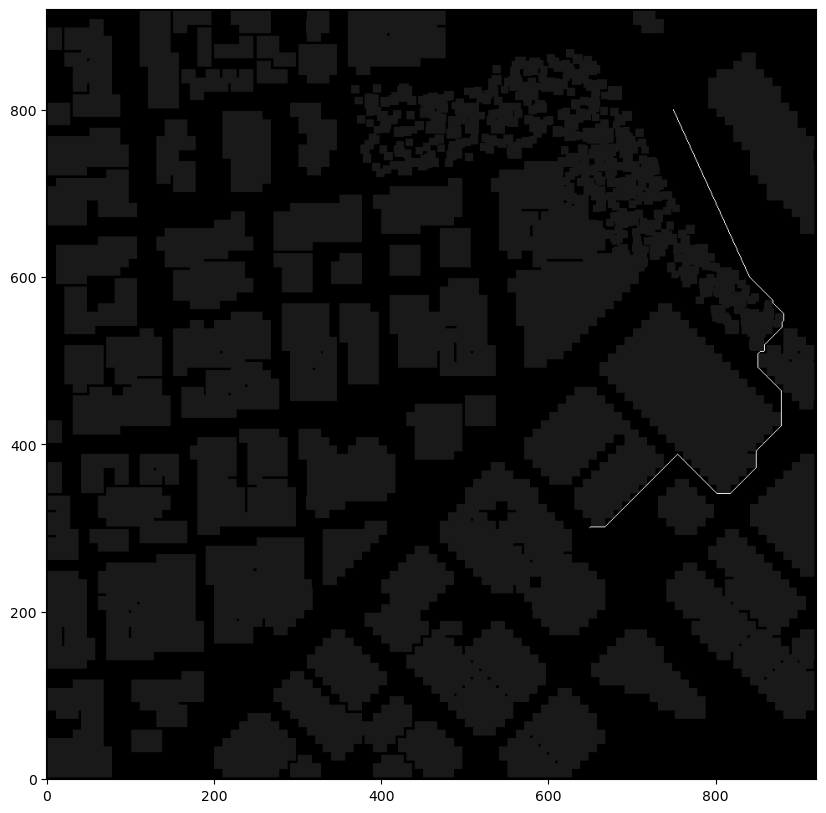

In [394]:
"""
This is the main script file for my planning project. 
"""
plt.rcParams["figure.figsize"] = [10, 10]
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', skiprows=2)
drone_altitude = 5
safe_distance = 3
grid = create_grid(data, drone_altitude, safe_distance)
start = (300, 650)
goal = (800, 750)
path, cost = a_star(grid, euclidean_heuristic, start, goal)
sgrid = visualize_path(grid, path, start)
visualize_path_waypoints(sgrid)

# Get waypoints from path
waypoints = path_to_waypoints(start, path)
culled_waypoints = remove_collinear_waypoints(waypoints)
print(culled_waypoints)